In [ ]:
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import FRED
if torch.__version__[:4] == '1.14': # If using pytorch with MPS, use Apple silicon GPU acceleration
    device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.has_mps else "cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
# sns.set_theme()
%load_ext autoreload
%autoreload 2

Using device cpu


# 05d01 PHATE on Single Cell Datasets
> Run PHATE on all of our toy datasets (optionally, do so many times), and produce training gifs and loss charts for each.

This is set up for the popular library `papermill`, which can parameterize and execute notebooks. 

First, we set the notebook-wide parameters, then run the cells. Papermill will create copies of the notebook with each parameter configuration given.

In [ ]:
notebook = "05d02 PHATE on Single Cell Datasets.ipynb"
dataset_name = "bone marrow"

In [ ]:
# Parameters
notebook = "05d02 PHATE Comparison on sc.ipynb"
dataset_name = "bone marrow"
output_label = "run_1"


# Set Up

In [ ]:
from FRED.datasets import double_helix, directed_swiss_roll_delayed, directed_sinh_branch, rnavelo, rnavelo_pcs
from FRED.data_processing import dataloader_from_ndarray, ManifoldWithVectorField
from torch.utils.data import DataLoader
import scvelo as scv
# choose correct dataset
if dataset_name == "bone marrow":
    adata = scv.datasets.bonemarrow()
    print("processing data with pcs")
    X, flow, labels, n_pcs = rnavelo_pcs(adata)
elif dataset_name == "dentategyrus":
    adata = scv.datasets.dentategyrus()
    print("processing data with pcs")
    X, flow, labels, n_pcs = rnavelo_pcs(adata)
elif dataset_name == "pancreas":
    adata = scv.datasets.pancreas()
    print("processing data with pcs")
    X, flow, labels, n_pcs = rnavelo_pcs(adata)

processing data with pcs


Normalized count data: X, spliced, unspliced.
Logarithmized X.


computing neighbors


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities


    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities


    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)


  0%|          | 0/5780 [00:00<?, ?cells/s]

    finished (0:00:19) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding


    finished (0:00:01) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


In [ ]:
X.shape

torch.Size([5780, 30])

## Set up the model

In [ ]:
from phate import phate
phate_op = phate.PHATE()

In [ ]:
phate_coords = phate_op.fit_transform(X)

Calculating PHATE...


  Running PHATE on 5780 observations and 30 variables.


  Calculating graph and diffusion operator...


    Calculating KNN search...


    Calculated KNN search in 0.55 seconds.


    Calculating affinities...


    Calculated affinities in 0.02 seconds.


  Calculated graph and diffusion operator in 0.57 seconds.


  Calculating landmark operator...


    Calculating SVD...


    Calculated SVD in 0.89 seconds.


    Calculating KMeans...


    Calculated KMeans in 9.61 seconds.


  Calculated landmark operator in 10.86 seconds.


  Calculating optimal t...


    Automatically selected t = 17


  Calculated optimal t in 6.77 seconds.


  Calculating diffusion potential...


  Calculated diffusion potential in 0.42 seconds.


  Calculating metric MDS...


  Calculated metric MDS in 2.33 seconds.


Calculated PHATE in 20.95 seconds.


# Results

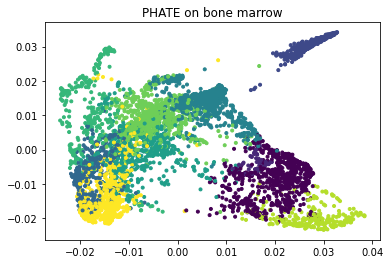

In [ ]:
from FRED.datasets import plot_directed_2d
velocities = np.zeros_like(phate_coords)
plot_directed_2d(phate_coords, velocities, labels, equal_aspect_ratio=False, title = f"PHATE on {dataset_name}")

# Qualitative analyses

We combine the embedded points with their velocities in the embedding space. 

In [ ]:
embedded_points = phate_coords
embedded_velocities = velocities
points_and_flows = np.concatenate([embedded_points, embedded_velocities], axis=1)
points_and_flows.shape

(5780, 4)

In [ ]:
import sklearn 
silhouette_points = sklearn.metrics.silhouette_score(embedded_points, labels)
silhouette_points_and_flows = sklearn.metrics.silhouette_score(points_and_flows, labels)

## Nearest Neighbors Classifier Score

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(points_and_flows, labels, test_size=0.33, random_state=42)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neighClass = KNeighborsClassifier(n_neighbors=3)
neighClass.fit(X_train, y_train)
knn_classifier_score = neighClass.score(X_test, y_test)

In [ ]:
print(f"## SCORES ## \n silhouette score w/o flows: {silhouette_points}.\n silhouette score w/ flows:  {silhouette_points_and_flows} \n kNN Classifier {knn_classifier_score}")

## SCORES ## 
 silhouette score w/o flows: 0.2359501964368528.
 silhouette score w/ flows:  0.2359501964368528 
 kNN Classifier 0.8113207547169812


# Write results to spreadsheet

In [ ]:
# create unique identifier for notebook
import secrets
import string
alphabet = string.ascii_letters + string.digits
unid = ''.join(secrets.choice(alphabet) for i in range(20))  # for a 20-character password
unid

'M6Kzd0ep19cCtiPtjCan'

In [ ]:
import csv
spread_name = notebook + "_dataset_" + dataset_name
with open(f"{spread_name}.csv", 'a') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(
        [unid,
         silhouette_points,
         silhouette_points_and_flows,
         knn_classifier_score
        ]) 